# GROUP 7 - Analytics and Applications

### Import of libraries

In [116]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import seaborn as sns
import ast

In [117]:
df = pd.read_csv("./Data/charging_sessions.csv")
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [119]:
print(df.isnull().sum())

Unnamed: 0              0
id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4088
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17263
userInputs          17263
dtype: int64


Finding: The columns doneChargingTime, userID, and userInputs have missing values.

In [120]:
# Check for duplicates
print(df.duplicated().sum())


0


Finding: There are no duplicates

In [121]:
# Check for invalid values
print(df[df['kWhDelivered'] < 0]),       


Empty DataFrame
Columns: [Unnamed: 0, id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, timezone, userID, userInputs]
Index: []


(None,)

Finding: There are no values with kWhDelivered < 0

# Data Cleaning


### Remove the column "Unnamed: 0" 
The column has 66450 empty values. This is equivalent to the amount of rows of the dataset, therefore it does not provide any value and can be removed. 

In [122]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### Replace "userID" na values with -1
There are 17263 data points with userID = na. Since this is a significant amount, removing the affected rows is not an option. 
To allow for further analysis in the upcoming milestones, it therefore makes sense to use a placeholder value.

In [123]:
df['userID'].fillna(-1, inplace=True)

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/3019672295.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['userID'].fillna(-1, inplace=True)


### Remove "doneChargingTime" na values 
There are 4088 data points with doneChargingTime = na. 
Interpolation is not an option at this point, since it is very difficult to interpolate values for a metric that is dependent from connectionTime. By trying to estimate the doneChargingTime for missing entries based on the connectionTime of this entry and the average time of other loading processes, we could manipulate the dataset, because the battery could have different states of charge at the start of charging.

In [124]:
df.dropna(subset=['doneChargingTime'], inplace=True)

### Remove the column "timezone"
Every timezone is set to "America/Los_Angeles", therefore it does not provide any value for further analysis and can be removed. 

In [125]:
df.drop(columns=['timezone'], inplace=True)

### Split UserInput to multiple features
The values of userInputs include valuable insides which can be relevant for further analysis. 
To ease the analysis later, we created coumns for the features within the userInputs string. 

In [126]:

#Function to parse 'userInputs' & extract the first dictionary
def parse_user_inputs(row):
    try:
        parsed = ast.literal_eval(row) if pd.notnull(row) else []
        return parsed[0] if isinstance(parsed, list) and len(parsed) > 0 else {}
    except (ValueError, SyntaxError):
        return {}

#Parse 'userInputs' column
df['userInputs'] = df['userInputs'].apply(parse_user_inputs)

#Specify desired features
desired_features = [
    'WhPerMile', 'kWhRequested', 'milesRequested', 
    'minutesAvailable', 'modifiedAt', 'paymentRequired', 
    'requestedDeparture'
]

#Extract desired features and create new columns
for feature in desired_features:
    df[feature] = df['userInputs'].apply(lambda x: x.get(feature) if isinstance(x, dict) else None)

#Drop the 'userInputs' column since it is no longer needed
df = df.drop(columns=['userInputs'])

## Convert time metrices and calculate hours 
For further analysis it is easier to work with dateTime objects. Also it is necessary to calculate the hours.

In [127]:

df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

#Calculate durations in hours
df['charging_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600
df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

In [128]:
df.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,charging_duration,session_duration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,250.0,25.0,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",4.378056,6.039167
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,280.0,70.0,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",6.687500,9.025278
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,400.0,8.0,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",2.641944,10.713056
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",1.313056,2.644722
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,400.0,16.0,40.0,504.0,"Thu, 02 Jan 2020 14:00:13 GMT",True,"Thu, 02 Jan 2020 22:24:01 GMT",4.291389,8.144167


# Outlier detection

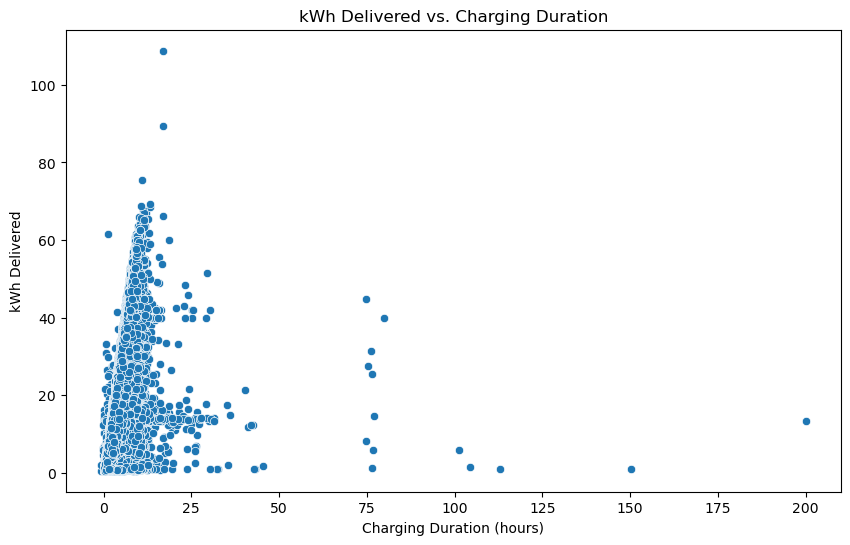

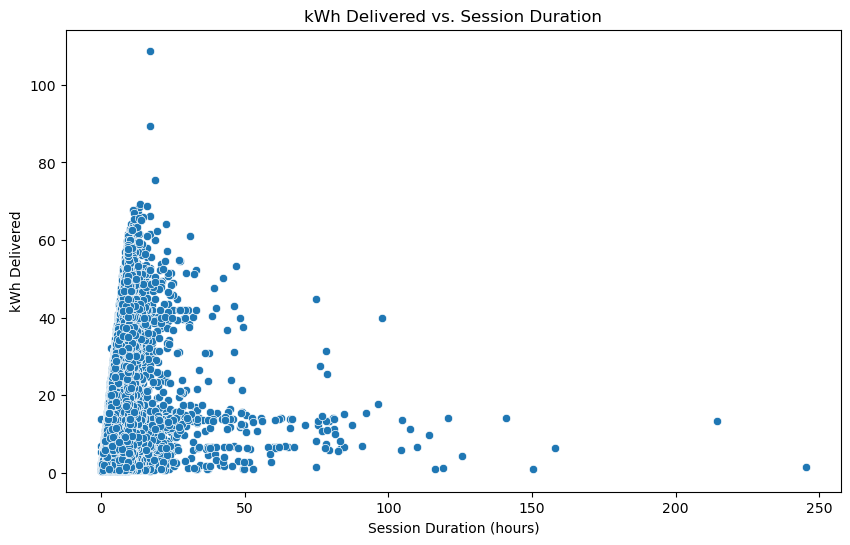

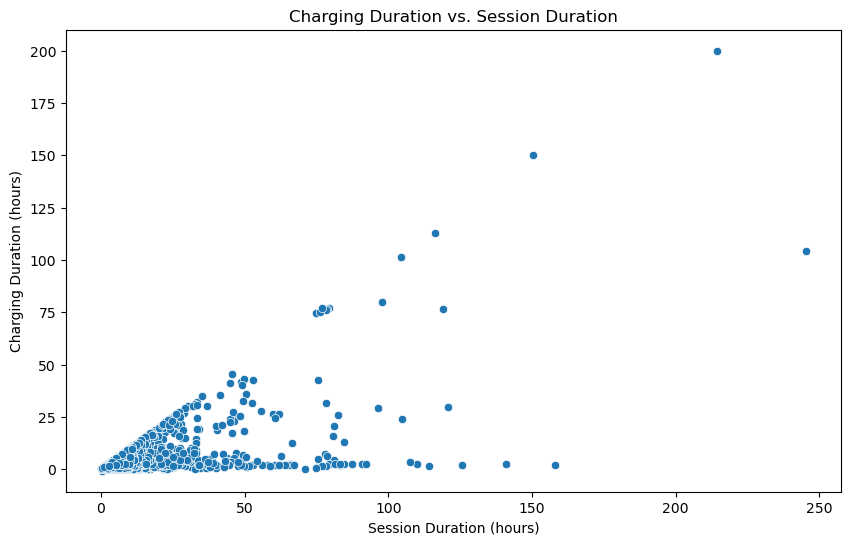

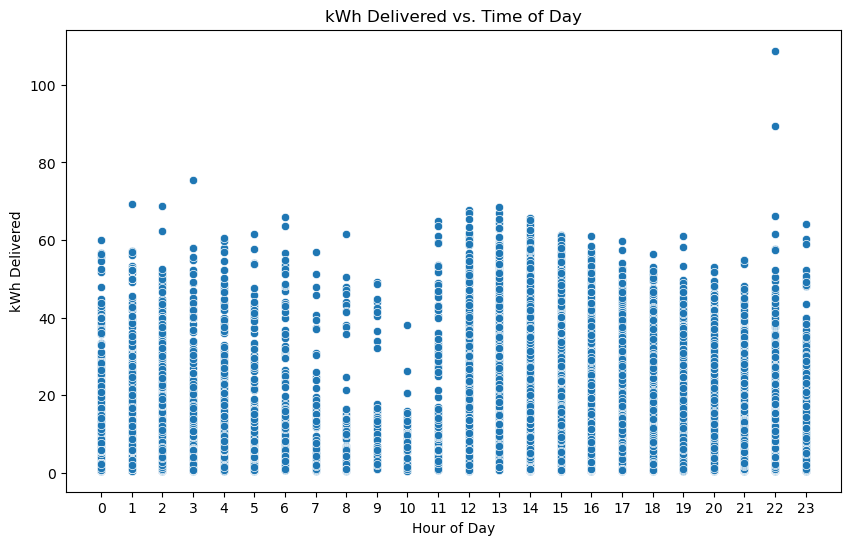

In [129]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.charging_duration, y=df.kWhDelivered)
plt.title('kWh Delivered vs. Charging Duration')
plt.xlabel('Charging Duration (hours)')
plt.ylabel('kWh Delivered')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.session_duration, y=df.kWhDelivered)
plt.title('kWh Delivered vs. Session Duration')
plt.xlabel('Session Duration (hours)')
plt.ylabel('kWh Delivered')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.session_duration, y=df.charging_duration)
plt.title('Charging Duration vs. Session Duration')
plt.xlabel('Session Duration (hours)')
plt.ylabel('Charging Duration (hours)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.connectionTime.dt.hour, y=df.kWhDelivered)
plt.title('kWh Delivered vs. Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('kWh Delivered')
plt.xticks(range(0, 24))
plt.show()

# Visualization 

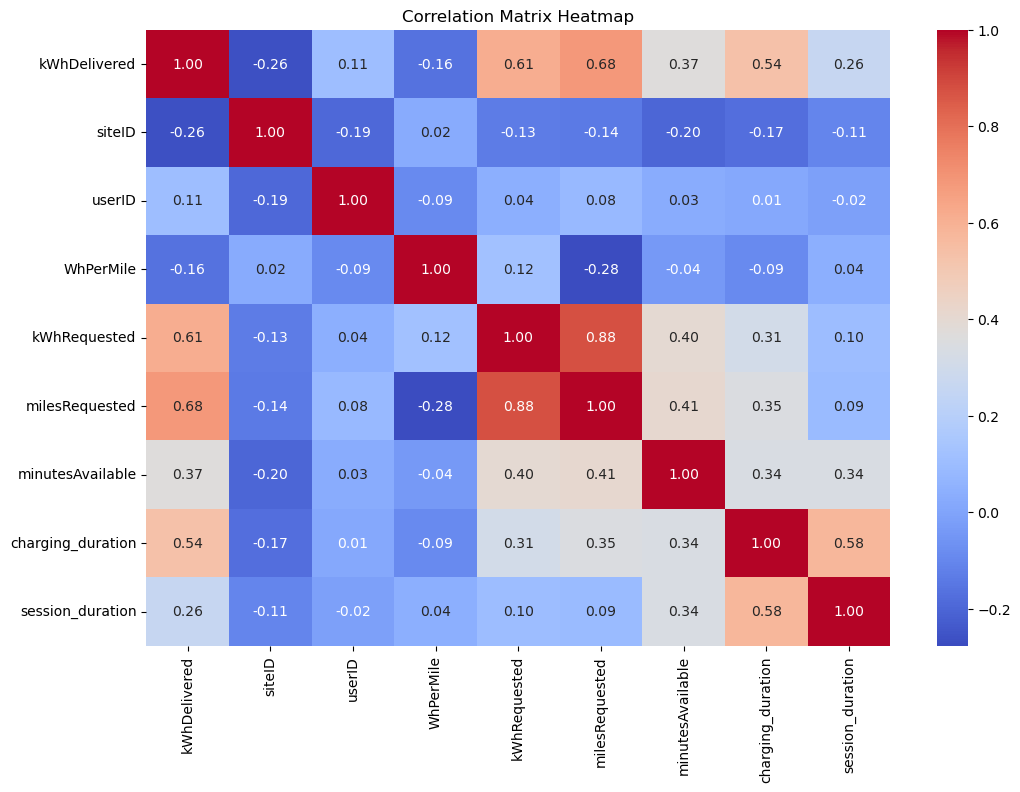

In [130]:
# Corr. matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()
# Finding: charging time has the largest "impact" on kWhDelivered

In [131]:
# Total Session Session Duration 
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 60
df['charging_time'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 60

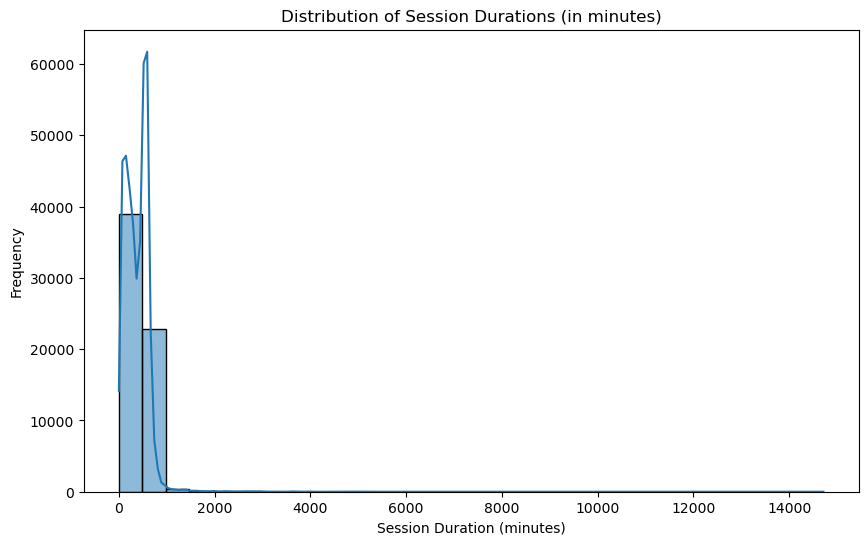

In [133]:
# Effective Charging time 
# Plot histogram of session durations
plt.figure(figsize=(10, 6))
sns.histplot(df['session_duration'], bins=30, kde=True)
plt.title("Distribution of Session Durations (in minutes)")
plt.xlabel("Session Duration (minutes)")
plt.ylabel("Frequency")
plt.show()


In [134]:
# Find entries with negative session_duration
print(df[df['session_duration'] < 0]),

Empty DataFrame
Columns: [id, connectionTime, disconnectTime, doneChargingTime, kWhDelivered, sessionID, siteID, spaceID, stationID, userID, WhPerMile, kWhRequested, milesRequested, minutesAvailable, modifiedAt, paymentRequired, requestedDeparture, charging_duration, session_duration, charging_time]
Index: []


(None,)

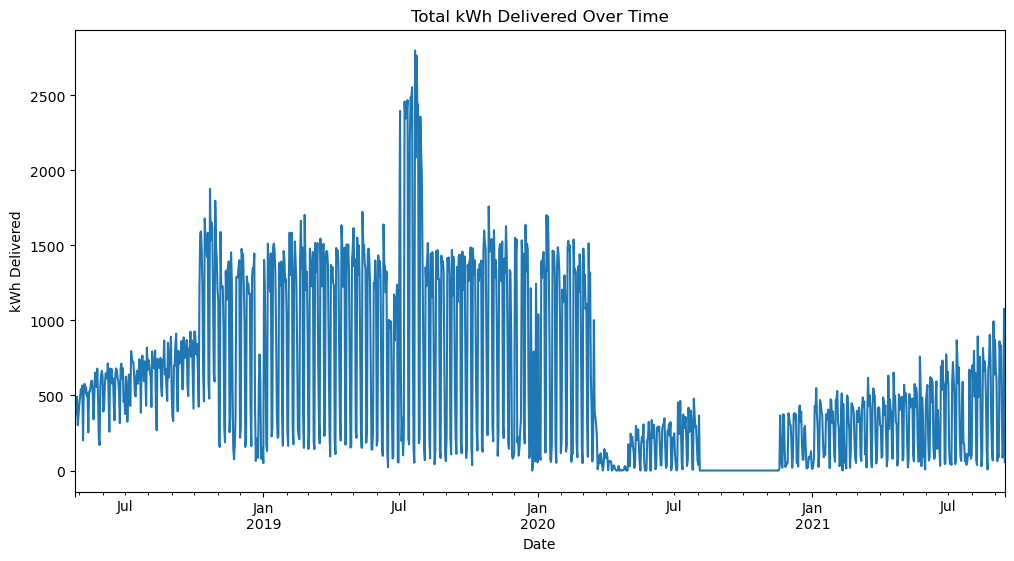

In [135]:
# kWh deilvered 
plt.figure(figsize=(12, 6))
df.set_index('connectionTime').resample('D')['kWhDelivered'].sum().plot()
plt.title("Total kWh Delivered Over Time")
plt.xlabel("Date")
plt.ylabel("kWh Delivered")
plt.show()

In [136]:
df

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,WhPerMile,kWhRequested,milesRequested,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,charging_duration,session_duration,charging_time
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,250.0,25.00,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",4.378056,362.350000,262.683333
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,280.0,70.00,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",6.687500,541.516667,401.250000
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,400.0,8.00,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",2.641944,642.783333,158.516667
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,400.0,8.00,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",1.313056,158.683333,78.783333
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,400.0,16.00,40.0,504.0,"Thu, 02 Jan 2020 14:00:13 GMT",True,"Thu, 02 Jan 2020 22:24:01 GMT",4.291389,488.650000,257.483333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66445,5d574ad2f9af8b4c10c03652,2019-07-31 18:08:04+00:00,2019-07-31 23:29:18+00:00,2019-07-31 23:30:18+00:00,28.787,1_1_179_809_2019-07-31 18:08:04.432654,1,AG-3F27,1-1-179-809,393.0,240.0,31.20,130.0,355.0,"Wed, 31 Jul 2019 18:08:23 GMT",True,"Thu, 01 Aug 2019 00:03:04 GMT",5.370556,321.233333,322.233333
66446,5d574ad2f9af8b4c10c03653,2019-07-31 18:40:41+00:00,2019-08-01 00:59:42+00:00,2019-07-31 21:44:23+00:00,7.787,1_1_179_810_2019-07-31 18:40:40.900203,1,AG-3F30,1-1-179-810,220.0,333.0,6.66,20.0,455.0,"Wed, 31 Jul 2019 18:41:02 GMT",True,"Thu, 01 Aug 2019 02:15:41 GMT",3.061667,379.016667,183.700000
66447,5d574ad2f9af8b4c10c03654,2019-07-31 19:04:40+00:00,2019-07-31 22:44:22+00:00,2019-07-31 22:45:21+00:00,11.274,1_1_191_795_2019-07-31 19:04:40.098273,1,AG-4F51,1-1-191-795,1974.0,333.0,19.98,60.0,184.0,"Wed, 31 Jul 2019 19:04:57 GMT",True,"Wed, 31 Jul 2019 22:08:40 GMT",3.678056,219.700000,220.683333
66448,5d574ad2f9af8b4c10c03655,2019-07-31 19:19:47+00:00,2019-08-01 00:34:51+00:00,2019-07-31 21:25:30+00:00,11.589,1_1_191_778_2019-07-31 19:19:46.919358,1,AG-4F43,1-1-191-778,942.0,275.0,22.00,80.0,60.0,"Wed, 31 Jul 2019 19:20:10 GMT",True,"Wed, 31 Jul 2019 20:19:47 GMT",2.095278,315.066667,125.716667


## Task 2

### A)

In [137]:
#Hour of Day
df["hour"] = df['connectionTime'].dt.hour

#Day of Week (Monday=0, Sunday=6)
df["dayOfWeek"] = df['connectionTime'].dt.dayofweek

#Month
df["month"] = df['connectionTime'].dt.month

#Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df["season"] = df['month'].apply(get_season)
hourly_counts = df.groupby('hour').size().reset_index(name='Charging Events')

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/1334498379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='Charging Events', data=hourly_counts, palette='Blues_d')


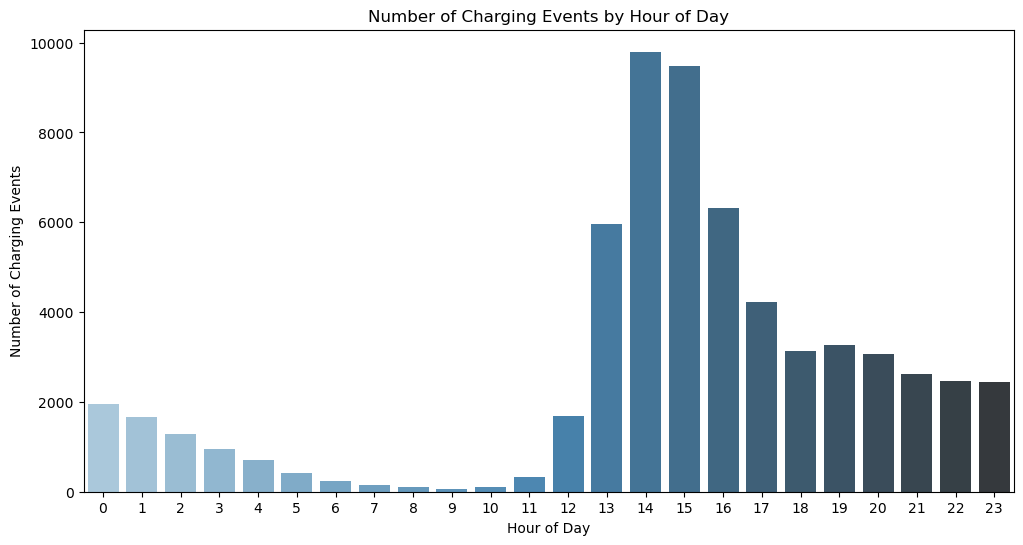

In [138]:
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=hourly_counts, palette='Blues_d')
plt.title('Number of Charging Events by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

### Mapping day numbers to names

In [139]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df['dayName'] = df['dayOfWeek'].map(day_names)

weekly_counts = df.groupby('dayName').size().reset_index(name='Charging Events')

### Ensure the days are in the correct order

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/583309710.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dayName', y='Charging Events', data=weekly_counts, palette='Greens_d')


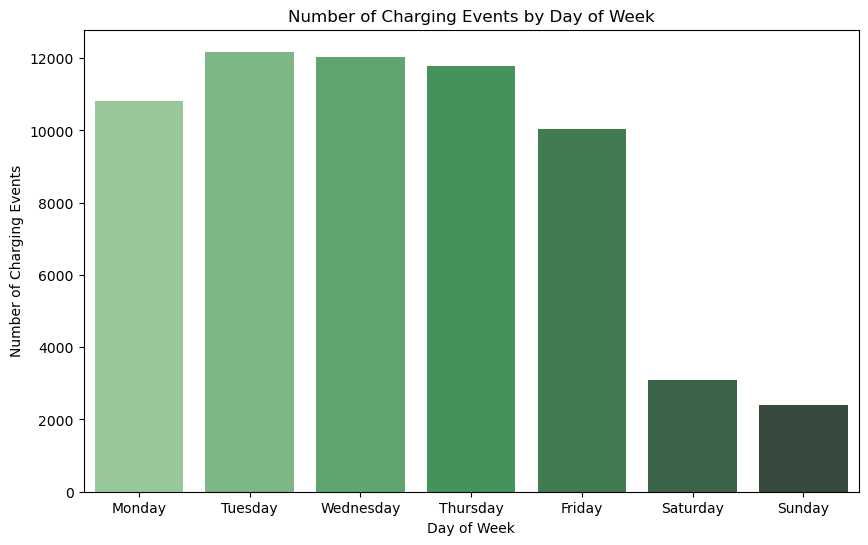

In [140]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts['dayName'] = pd.Categorical(weekly_counts['dayName'], categories=order, ordered=True)
weekly_counts = weekly_counts.sort_values('dayName')

plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts, palette='Greens_d')
plt.title('Number of Charging Events by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/2141839377.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='Charging Events', data=monthly_counts, palette='Oranges_d')


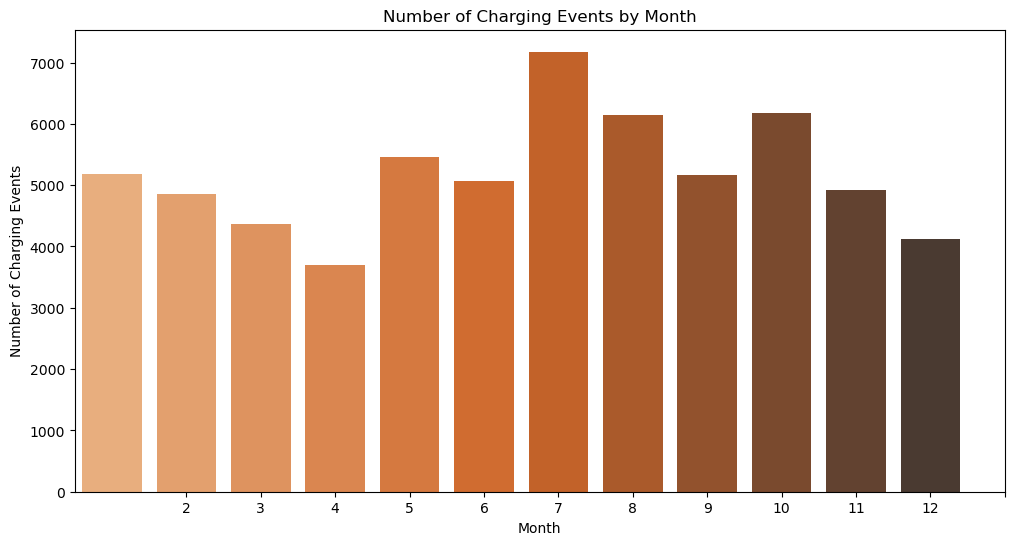

In [141]:
monthly_counts = df.groupby('month').size().reset_index(name='Charging Events')
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='Charging Events', data=monthly_counts, palette='Oranges_d')
plt.title('Number of Charging Events by Month')
plt.xlabel('Month')
plt.ylabel('Number of Charging Events')
plt.xticks(range(1, 13))
plt.show()

# C

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/2500268233.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='Charging Events', data=df_site1.groupby('hour').size().reset_index(name='Charging Events'), palette='Blues_d')


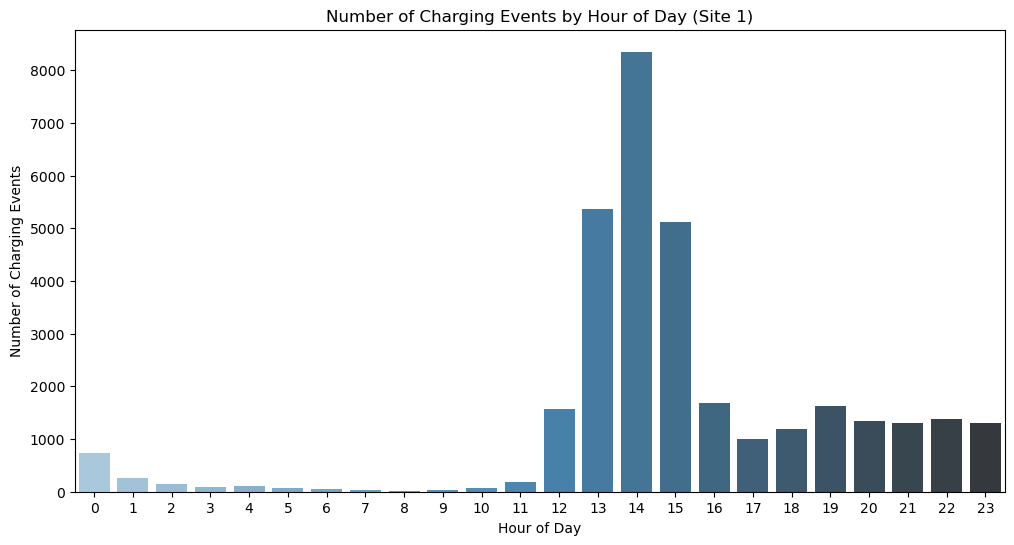

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/2500268233.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='Charging Events', data=df_site2.groupby('hour').size().reset_index(name='Charging Events'), palette='Greens_d')


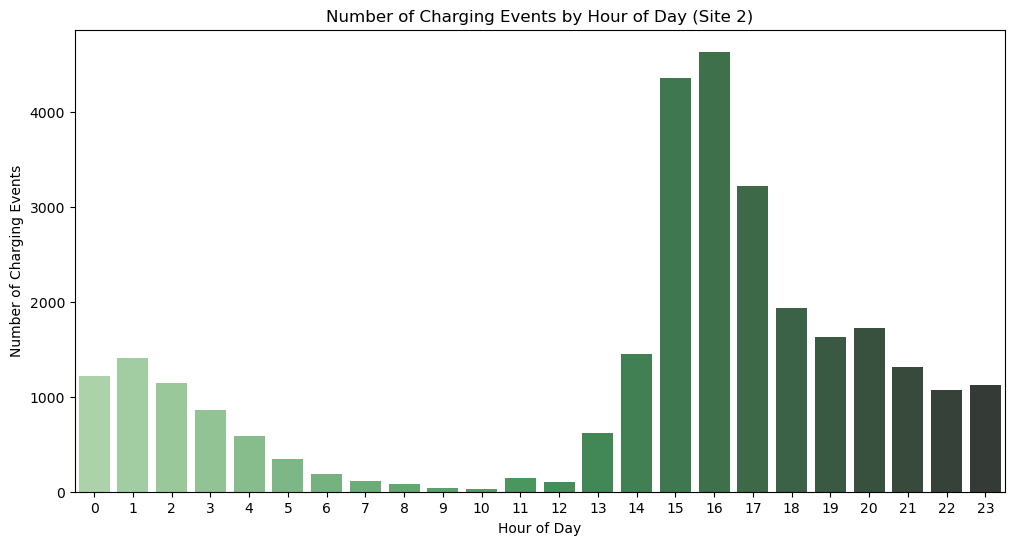

In [142]:
# Filter the dataframe for siteID=1 and siteID=2
df_site1 = df[df['siteID'] == 1]
df_site2 = df[df['siteID'] == 2]

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=df_site1.groupby('hour').size().reset_index(name='Charging Events'), palette='Blues_d')
plt.title('Number of Charging Events by Hour of Day (Site 1)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Charging Events', data=df_site2.groupby('hour').size().reset_index(name='Charging Events'), palette='Greens_d')
plt.title('Number of Charging Events by Hour of Day (Site 2)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Charging Events')
plt.xticks(range(0, 24))
plt.show()

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/2071956854.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dayName', y='Charging Events', data=weekly_counts_site1, palette='Blues_d')


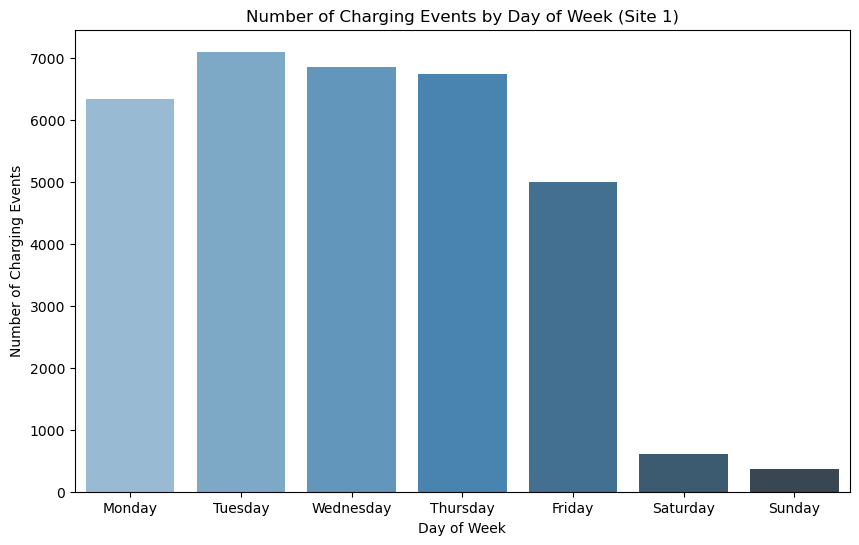

/var/folders/9g/v34g8lv55fl28x64t_hf8m000000gr/T/ipykernel_30901/2071956854.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dayName', y='Charging Events', data=weekly_counts_site2, palette='Greens_d')


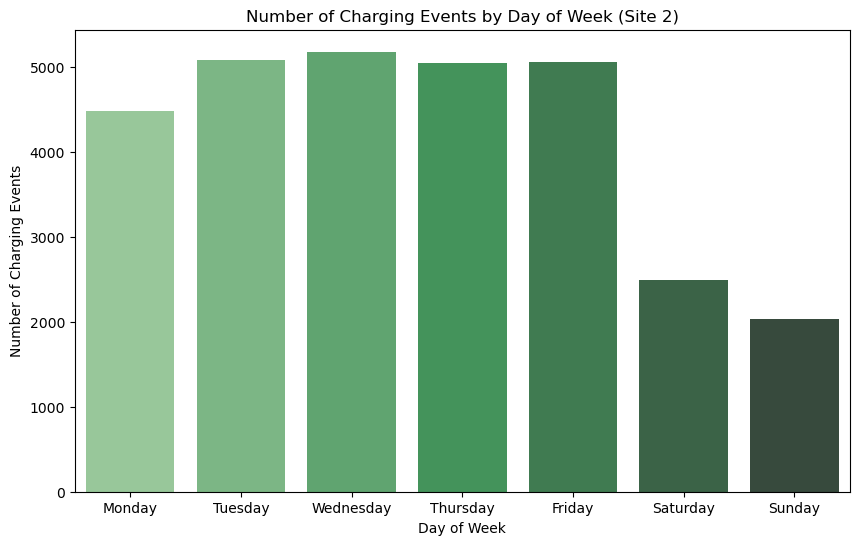

In [143]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts['dayName'] = pd.Categorical(weekly_counts['dayName'], categories=order, ordered=True)
weekly_counts = weekly_counts.sort_values('dayName')

# Group by dayName and count the number of charging events
weekly_counts_site1 = df_site1.groupby('dayName').size().reset_index(name='Charging Events')

# Ensure the days are in the correct order
weekly_counts_site1['dayName'] = pd.Categorical(weekly_counts_site1['dayName'], categories=order, ordered=True)
weekly_counts_site1 = weekly_counts_site1.sort_values('dayName')

# Plot the number of charging events by day of week for siteID=1
plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts_site1, palette='Blues_d')
plt.title('Number of Charging Events by Day of Week (Site 1)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()

# Group by dayName and count the number of charging events for siteID=2
weekly_counts_site2 = df_site2.groupby('dayName').size().reset_index(name='Charging Events')

# Ensure the days are in the correct order
weekly_counts_site2['dayName'] = pd.Categorical(weekly_counts_site2['dayName'], categories=order, ordered=True)
weekly_counts_site2 = weekly_counts_site2.sort_values('dayName')

# Plot the number of charging events by day of week for siteID=2
plt.figure(figsize=(10, 6))
sns.barplot(x='dayName', y='Charging Events', data=weekly_counts_site2, palette='Greens_d')
plt.title('Number of Charging Events by Day of Week (Site 2)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Charging Events')
plt.show()
